# VERIFICATION AND VALIDATION - EXERCISES



# Preliminaries

In [ ]:
IS_COLAB = True

In [ ]:
if IS_COLAB:
    !pip install -q tellurium
    !pip install -q SBMLLint
    pass

## Imports

In [ ]:
# Python packages used in this section
import os
import matplotlib.pyplot as plt
import numpy as np
import urllib.request # use this library to download file from GitHub
from SBMLLint.tools.sbmllint import lint
import tellurium as te

In [ ]:
# Constants
ENDTIME = 10
NUMPOINT = 10*ENDTIME

In [ ]:
def getSharedCodes(moduleName):
  """
  Obtains common codes from the github repository.

  Parameters
  ----------
  moduleName: str
      name of the python module in the src directory
  """
  if IS_COLAB:
      url = "https://github.com/sys-bio/network-modeling-summer-school-2021/raw/main/src/%s.py" % moduleName
      local_python = "python.py"
      _, _ = urllib.request.urlretrieve(url=url, filename=local_python)
  else:
      local_python = "../../src/%s.py" % moduleName
  with open(local_python, "r") as fd:
    codeStr = "".join(fd.readlines())
  print(codeStr)
  exec(codeStr, globals())

# Acquire codes
getSharedCodes("util")

# TESTS
assert(isinstance(LINEAR_PATHWAY_DF, pd.DataFrame))

import pandas as pd
import urllib.request

# Linear pathway data
BASE_URL = "https://github.com/vporubsky/network-modeling-summer-school/raw/main/"
BASE_DATA_URL = "%sdata/" % BASE_URL
BASE_MODULE_URL = "%ssrc/" % BASE_URL
BASE_MODEL_URL = "%smodels/" % BASE_URL
LOCAL_FILE = "local_file.txt"


def getData(csvFilename):
    """
    Creates a dataframe from a CSV structured URL file.

    Parameters
    ----------
    csvFilename: str
        Name of the CSV file (w/o ".csv" extension)

    Returns
    -------
    pd.DataFrame
    """
    url = "%s%s.csv" % (BASE_DATA_URL, csvFilename)
    filename, _ = urllib.request.urlretrieve(url, filename=LOCAL_FILE)
    return pd.read_csv(LOCAL_FILE)

def getModule(moduleName):
    """
    Obtains common codes from the github repository.
  
    Parameters
    ----------
    moduleName: str
        name of the python module in the src directory
    """
    url = "%s%s.py" % (BASE_MODULE_URL, moduleName)
    _, _ = urllib.request.urlretrieve(url, fil

## Constants

### Wolf model

In [ ]:
print(WOLF_MODEL)

// Created by libAntimony v2.12.0.3
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceralde

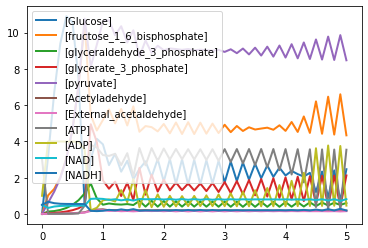

In [ ]:
rr = te.loada(WOLF_MODEL)
rr.plot(rr.simulate())

### Global constants

In [ ]:
# Constants used in the section
MOLECULES = ["Glucose", "fructose_1_6_bisphosphate", "glyceraldehyde_3_phosphate", "glycerate_3_phosphate",
            "pyruvate", "Acetyladehyde", "External_acetaldehyde", "ATP", "ADP", "NAD", "NADH"]
ENDTIME = 5
NUMPOINT = 100*ENDTIME
ROADRUNNER = te.loada(WOLF_MODEL)

# Exercise 1: Mass Balance Errors
1. Use SBMLLint to find mass check for mass balance errors in the Wolf model.

1. Reaction ``J9`` implies that ``ATP`` and ``ADP`` have the same mass, which is clearly false since they differ
by an inorganic phosphate.
Revise the Wolf model to explicitly include
inorganic phosphate and check your revised model
with SBMLLint.
Do you get the same dynamics with the revised model
as with the original Wolf model?

## (1) Check for mass balance
We begin by checking if the Wolf model has any stoichiometric inconsistencies.
First, we create the antimony model as a string.

In [ ]:
_ = lint(WOLF_MODEL, mass_balance_check="games")

Model analyzed...
No error found.


## (2) Revise the Wolf model to include inorganic phosphate

In [ ]:
REVISED_WOLF_MODEL = """
species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  // **Added P to products
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP + 2 P; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  // **Added P to reactants and kinetics
  J4: glyceraldehyde_3_phosphate + ADP + P + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP*P - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  // **Added P to reactants and kinetics
  J5: glycerate_3_phosphate + ADP + P => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP*P;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  // **Added P to products
  J9: ATP => ADP + P; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  P = 1.7;  # added inorganic phosphate
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50;
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;
  
  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k;
  const J4_kg, J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2;
  const J9_k, J10_k;
"""

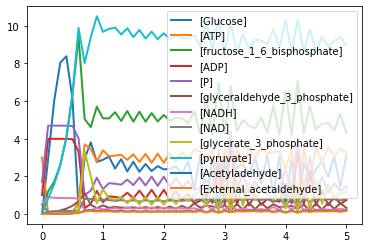

In [ ]:
# Make sure that the model works

rr = te.loada(REVISED_WOLF_MODEL)
rr.plot(rr.simulate())

In [ ]:
_ = lint(REVISED_WOLF_MODEL, mass_balance_check="games")

Model analyzed...
No error found.


There dynamics are not the same as with the original Wolf model since the interpretations and values of some kinetics constants are different because of the inclusion of ``P`` in ``J4`` and ``J5``.

# Exercise 2: Dynamic Tests

This exercise uses the Wolf model of glycolytic oscillations.

1. What is the relationship between the concentrations of
glucose, furctose_1_6_bisphosphate, and pyruvate after the initial transients.
Does this relationship always hold?

1. Propose a test that checks for that the order of the concentrations at steady state of glucose, furctose_1_6_bisphosphate, and pyruvate.
Hint: Implement a function that checks that one vector
is greater than a second vector after a specified index.

1. Another characteristic of the Wolf model is the presence of oscillations at the same frequency.
Describe in words how you would implement a test to
checks for the presence of these oscillations.

## (1) Relationships between concentrations

After the initial transient, the concentration of
pyruvate is almost always larger than the concentration of furctose_1_6_bisphosphate which is almost always larger than glucose.

The ordinal relationship holds a large fraction of the time but not *all* of the time.
The plots below show this.

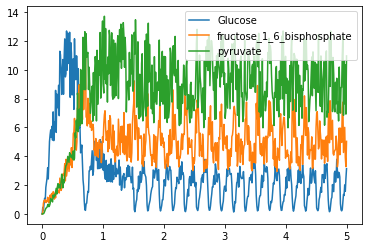

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(WOLF_DF["time"], WOLF_DF["Glucose"])
ax.plot(WOLF_DF["time"], WOLF_DF["fructose_1_6_bisphosphate"])
ax.plot(WOLF_DF["time"], WOLF_DF["pyruvate"])
ax.legend(["Glucose", "fructose_1_6_bisphosphate", "pyruvate"])

## (2) Test for relative size of concentrations

In [ ]:
def isLarger(ser1, ser2, fractionTrue=1.0, startIdx=0):
    """
    Checks that arr1[startIdx:] > arr2[startIdx:]

    Parameters
    ----------
    ser1: pd.Series
    ser2: pd.Series
    fractionTrue: float in [0, 1]
    startIdx: int

    Returns
    -------
    bool
    """
    numTrue = sum(ser1.loc[startIdx:] > ser2.loc[startIdx:])
    result = 1.0*numTrue / (len(ser1) - startIdx)
    return result >= fractionTrue

# TESTS
ser1 = pd.Series(range(10))
ser2 = pd.Series(range(-10, 0))
assert(isLarger(ser1, ser2))
assert(not isLarger(ser2, ser1))
assert(not isLarger(ser1, ser2, fractionTrue=1.1)) # Test fractionTrue

In [ ]:
import unittest

# Performs unittests on wolf model

# Define a class in which the tests will run
class TestWolfModel(unittest.TestCase):
    
    def setUp(self):
        self.df = WOLF_DF
        self.startIdx = 400
        
    def testPyruvateGlucose(self):
        self.assertTrue(isLarger(self.df["pyruvate"],
                                # self.df["fructose_1_6_bisphosphate"],
                                 self.df["Glucose"],
                                 startIdx=self.startIdx,
                                 fractionTrue=1.0))
        
    def testFructoseGlucose(self):
        self.assertTrue(isLarger(self.df["fructose_1_6_bisphosphate"],
                                 self.df["Glucose"], 
                                 fractionTrue=0.95,
                                 startIdx=self.startIdx))
        
    def testPyruvateFructose(self):
        self.assertTrue(isLarger(self.df["pyruvate"],
                                # self.df["fructose_1_6_bisphosphate"],
                                 self.df["fructose_1_6_bisphosphate"],
                                 startIdx=self.startIdx,
                                 fractionTrue=0.95))
        
suite = unittest.TestLoader().loadTestsFromTestCase(TestWolfModel)
_ = unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.006s

OK


## (3) Frequency Tests

After the initial transient of about 2 sec, concentrations oscillate. One way to characterize oscillations is by using the fourier transform. To construct tests, we could implement the function ``getFft`` that calculates the fast fourier transform
(FFT) for a chemical species, and a second function, ``isOscillate``, that checks to calls ``getFft`` to determine if oscillations of the expected frequency are present.